In [1]:
import numpy as np
#from scipy import interpolate
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize

np.random.seed(1)
#%load_ext autotime
%matplotlib inline

In [2]:
##
# Grids
##
#y_grid = 10+30*np.array([range(0,50)]).reshape(50)
#state_grid = np.array([200,250])
#b_grid = 5*np.array(range(0,100))

y_grid = 100000 + 5000*np.arange(400)
#check if required
y_grid = y_grid.reshape(400)
b_grid = 20000 + 5000*np.arange(0,600)
lyg = len(y_grid) 

#lbg = len(b_grid)

In [3]:
##
# Parameters
##
beta = 0.95
alpha = 10
w = np.array([0.1,0.5,4])
param = np.append(alpha,w)
J = len(w)
rho = np.ones(np.shape(w))/np.shape(w)
sigma=0.1
n_draws = 200
# distribution of own returns
#distr_R = np.array( np.random.uniform(0.95,1.05,n_draws) )
#distr_R = np.array( np.random.uniform(1,1,n_draws) )
#bidders / income distribution
N = 100
b = 0.1
#var_income = 1.2
#y_realis_1 = np.random.lognormal(np.log(200),np.log(var_income),np.round(N))
#y_realis_1 = np.array([np.random.lognormal(np.log(s),np.log(var_income),N) for s in state_grid])


# States

In [4]:
#import stock market level
df=pd.read_csv("simulation_data/avgsp.csv", sep=",")
state_grid = 200.0*np.arange(2,11)
lsg = len(state_grid)

#assign states to S&P Data

#round S&P level to nearest grid point
df['state'] = [400+200*np.round((sp-400)/200,0) for sp in df['avgsp']]

#calculate return
df['return'] = [df['avgsp'][i+1]/df['avgsp'][i] for i in range(len(df)-1)] + ['NA']

df

,Unnamed: 0,season,avgsp,state,return
0,1,1992,448.303753,400,1.028869
1,2,1993,461.245832,400,1.088237
2,3,1994,501.945005,600,1.260932
3,4,1995,632.918330,600,1.265698
4,5,1996,801.083338,800,1.282998
5,6,1997,1027.788335,1000,1.213912
6,7,1998,1247.644999,1200,1.138104
7,8,1999,1419.950002,1400,0.9003773
8,9,2000,1278.490814,1200,0.8300242
9,10,2001,1061.178324,1000,0.8571863


## Transition Probabilities between States

For now assume transition probabilities according to relative frequency of each state, regardless of current state (conditional and unconditional probabilities are the same)

In [5]:
#def myfunc(s):
 #   for i in range(s):
  #      yield np.sum(1*(df['state']==state_grid[i]))/(len(df)-1.00)
#

#%timeit np.fromiter(myfunc(length), dtype=int)
#%timeit
state_freq = np.array([np.sum(1*(df['state']==s))/(len(df)-1.00) for s in state_grid])

transition_probs = np.tile(state_freq,lsg).reshape(lsg,lsg)

## Distribution of Returns by State

For now assume expectations over returns are the same in all states.

In [6]:
#Realised returns in S&P Data
realis_sp_return = np.array([df['avgsp'][i+1]/df['avgsp'][i] for i in range(len(df)-1)])

#Individual Returns: one of the realised returns plus idiosyncratic noise

distr_mean_R = np.array(np.random.choice(realis_sp_return,size=n_draws,replace=True))

distr_R = distr_mean_R + np.random.uniform(-0.05,+0.05,n_draws)

distr_R_states = np.array([distr_R for s in state_grid])
distr_R_states

array([[1.24811548, 1.03793048, 1.05053273, ..., 1.13454121, 0.82773831,
        0.93218076],
       [1.24811548, 1.03793048, 1.05053273, ..., 1.13454121, 0.82773831,
        0.93218076],
       [1.24811548, 1.03793048, 1.05053273, ..., 1.13454121, 0.82773831,
        0.93218076],
       ...,
       [1.24811548, 1.03793048, 1.05053273, ..., 1.13454121, 0.82773831,
        0.93218076],
       [1.24811548, 1.03793048, 1.05053273, ..., 1.13454121, 0.82773831,
        0.93218076],
       [1.24811548, 1.03793048, 1.05053273, ..., 1.13454121, 0.82773831,
        0.93218076]])

In [7]:
np.mean(distr_R)

1.0688778531588485

## Income Distribution by State

In [8]:
y_realis_1 = np.random.lognormal(np.log(150000),np.log(2),np.round(N))

state_grid_change = np.array([state_grid[i]/state_grid[0] for i in range(lsg)])

#mean wealth
#50% of wealth invested in the stock market
mean_wealth_state = np.array([75000 + state_grid_change[s]*75000 for s in range(lsg)])

y_realis_states = np.array([np.random.lognormal(np.log(mean_wealth_state[s]),np.log(2),np.round(N)) for s in range(lsg)])



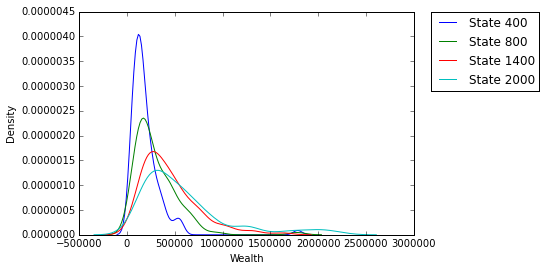

In [9]:
fig, ax = plt.subplots()
for s in [0,2,5,8]: sns.distplot(y_realis_states[s,:],hist=False, label="State %d" %state_grid[s])
ax.set_xlabel("Wealth")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Bid Function

$b_j(y,s) = \theta y (w_j + \beta(\textbf{E}[S_j(y',s') | y-b_j(y,s),s] - \textbf{E}[B(y',s') | y,s] ))$

# Buyer Value Function

\begin{align*}
  B_{j}(y,s) =& \alpha \text{ln}((1-\beta) y) + (1-\sigma \textbf{Pr}[b_j(y,s)>\bar{b}_j])\cdot \beta \textbf{E}[B(y',s') | y,s] +\\
  &\sigma \cdot \int \Big( \textbf{1}(b_j(y,s)>\bar{b}_j) \big(w_j - \frac{\theta}{y} \bar{b}_j + \beta  \textbf{E}[S_j(y',s') | y-\bar{b}_j,s] \big) \Big) dG_{\bar{b}_j |s} \\
\end{align*}



# Seller Value Function

\begin{align*}
  S_{j}(y,s) =& \alpha \text{ln}((1-\beta) y) + (1-\rho_j)\cdot(w_j + \beta \textbf{E}[S_j(y',s') | y,s] ) + \\
  & \rho_j \cdot \int \Big( \text{max}\{ \frac{\theta}{y} b_{j,(2)} + \textbf{E}[B(y',s') | y+b_{j,(2)},s] ,\ w_j + \beta \textbf{E}[S_j(y',s') | y,s] \} \Big) dH_{b_{j,(2)} |s}
\end{align*}



## ------------------------------------------------------------------------------------
## New Approach
## ------------------------------------------------------------------------------------

Interpolate EB and ES in addition to interpolate B and S. Saves time by saving on many MC integrations.

In [10]:
def bid_fn2(f_param,f_set,f_EB,f_ES_interp):
    (f_beta,f_rho,f_w,f_J,f_alpha) = (f_param[0],f_param[1],f_param[2],f_param[3],f_param[4])
    (f_y_grid,f_lyg,f_b_grid,f_n_draws,f_state_grid) = (f_set[0],f_set[1],f_set[2],f_set[3],f_set[4])
    (f_lyg,f_lbg,f_lsg) = (len(f_y_grid),len(f_b_grid),len(f_state_grid))
    y_buy = y_grid.reshape(f_lyg,1) - b_grid.reshape(1,f_lbg)
    ES_buy = np.array([[f_ES_interp[j,s](y_buy) for s in np.arange(f_lsg)] for j in np.arange(f_J)])
    error = (f_alpha/(1-f_beta)) * f_y_grid.reshape(1,1,f_lyg,1) * (f_w.reshape(f_J,1,1,1) + f_beta*(ES_buy - f_EB.reshape(1,f_lsg,f_lyg,1))) - f_b_grid.reshape(1,1,1,f_lbg)
    return f_b_grid[np.argmin(error**2,axis=3)]

In [11]:
def fn_B2(f_param,f_set,f_EB,f_ES_interp,bid_now,distr_b_bar_now):
    (f_beta,f_rho,f_w,f_J,f_alpha,f_sigma) = (f_param[0],f_param[1],f_param[2],f_param[3],f_param[4],f_param[5])
    (f_y_grid,f_lyg,f_b_grid,f_n_draws,f_state_grid) = (f_set[0],f_set[1],f_set[2],f_set[3],f_set[4])
    (f_lyg,f_lbg,f_lsg) = (len(f_y_grid),len(f_b_grid),len(f_state_grid))
    win_bool = (bid_now.reshape(f_J,f_lsg,f_lyg,1)>distr_b_bar_now.reshape(f_J,f_lsg,1,f_n_draws)) #dimensions: J x states x y_gridpoints x n_draws
    win_prob = np.mean(win_bool,axis=3) #dimensions: J x states x y_gridpoints
    #V1 = utility of composite good consumption plus continuation value of not winning (if inactive or active but losing the auction)
    V1 = (f_alpha*np.log((1-f_beta)*f_y_grid)).reshape(1,1,f_lyg) + (1-f_sigma*win_prob)*f_beta*f_EB.reshape(1,f_lsg,f_lyg) #dimensions: J x states x y_gridpoints
    #V2 = expected utility of winning
    y_buy = y_grid.reshape(1,1,f_lyg,1) - distr_b_bar_now.reshape(f_J,f_lsg,1,f_n_draws) #dimensions: J x S x Y x n_draws (b_bar)
    ES_buy = np.array([[f_ES_interp[j,s](y_buy[j,s,:,:]) for s in np.arange(f_lsg)] for j in np.arange(f_J)]) #dimensions: J x S x Y x n_draws (b_bar)
    V2_per_b_bar = f_w.reshape(f_J,1,1,1) - (f_alpha*distr_b_bar_now.reshape(f_J,f_lsg,1,f_n_draws) / ((1-f_beta) * f_y_grid.reshape(1,1,f_lyg,1))) + f_beta*ES_buy #dimensions: J x S x Y x n_draws (b_bar)
    V2 = f_sigma*np.mean(win_bool * V2_per_b_bar,axis=3)
    return V1 + V2
 
#dimensions: J x S x n_draws    

In [12]:
def fn_S2(f_param,f_set,f_EB_interp,f_ES,distr_b_2_now):
    (f_beta,f_rho,f_w,f_J,f_alpha,f_sigma) = (f_param[0],f_param[1],f_param[2],f_param[3],f_param[4],f_param[5])
    (f_y_grid,f_lyg,f_b_grid,f_n_draws,f_state_grid) = (f_set[0],f_set[1],f_set[2],f_set[3],f_set[4])
    (f_lyg,f_lbg,f_lsg) = (len(f_y_grid),len(f_b_grid),len(f_state_grid))
    keep = (f_w.reshape(f_J,1,1) + f_beta * f_ES) #dim: J x S x Y
    #V1 = utility of composite good consumption plus continuation value of keeping the car if not picked for auction
    V1 = (f_alpha*np.log((1-f_beta)*f_y_grid)).reshape(1,1,f_lyg) + (1-f_rho.reshape(f_J,1,1)) * keep
    #V2 = expected utility of having car picked for auction
    y_sell = y_grid.reshape(1,1,f_lyg,1) - distr_b_2_now.reshape(f_J,f_lsg,1,f_n_draws) #dimensions: J x S x Y x n_draws (b_2)
    EB_sell = np.array([[f_EB_interp[s](y_sell[j,s,:,:]) for s in np.arange(f_lsg)] for j in np.arange(f_J)]) #dimensions: J x S x Y x n_draws (b_2)
    sell_per_b_2 = (f_alpha*distr_b_2_now.reshape(f_J,f_lsg,1,f_n_draws) / ((1-f_beta) * f_y_grid.reshape(1,1,f_lyg,1))) + f_beta*EB_sell #dimensions: J x states x y_gridpoints x n_draws (b_2)
    keep_broadc = np.repeat(keep.reshape(f_J,f_lsg,f_lyg,1),f_n_draws,axis=3)
    V2_per_b_2 = np.max(np.array([keep_broadc,sell_per_b_2]),axis=0) #pick max of selling or keeping for each draw from distribution of b_2 (since seller decides to sell or not after observing the bids)
    #V2_per_b_2 = sell_per_b_2 #ignore reserve price for now
    V2 = f_rho.reshape(f_J,1,1) * np.mean(V2_per_b_2,axis=3) #integrate over distribution of b_2
    return V1 + V2

In [13]:
def fn_iterate(f_param,f_set,
               B_start,S_start,n_iter,
              f_distr_R_states,f_transition_probs,
              f_y_realis,f_rival_bidders_ids,f_active_bidders_ids):
    (f_beta,f_rho,f_w,f_J,f_alpha,f_sigma) = (f_param[0],f_param[1],f_param[2],f_param[3],f_param[4],f_param[5])
    (f_y_grid,f_lyg,f_b_grid,f_n_draws,f_state_grid) = (f_set[0],f_set[1],f_set[2],f_set[3],f_set[4])
    (f_lyg,f_lbg,f_lsg) = (len(f_y_grid),len(f_b_grid),len(f_state_grid))
    check = []
    bids_iter = []
    Buyer_iter = []
    (B1,S1) = (B_start,S_start)
    for t in np.arange(n_iter):
        # interpolate B1 and S1
        B1_interp = np.array([[interp1d(y_grid,B1[j,s,:],fill_value='extrapolate') for s in np.arange(f_lsg)] for j in np.arange(f_J)])
        S1_interp = np.array([[interp1d(y_grid,S1[j,s,:],kind='linear',fill_value='extrapolate') for s in np.arange(f_lsg)] for j in np.arange(f_J)])
        # Calculate EB1
        distr_y_next = beta * f_distr_R_states.reshape(f_lsg,1,f_n_draws) * f_y_grid.reshape(1,f_lyg,1) #dimensions: state_gridpoints x y_gridpoints x n_draws
        EB_per_state_1 = np.array([[np.mean(B1_interp[j,s](distr_y_next[s,:,:]), axis=1) for s in np.arange(f_lsg)] for j in np.arange(J)]) #dimenstions: J x states x y
        EB1 = np.sum([f_rho[j]*np.dot(f_transition_probs,EB_per_state_1[j,:,:]) for j in np.arange(f_J)],axis=0) #dimensions: states x y
        # interpolate EB1
        EB1_interp = np.array([interp1d(y_grid,EB1[s,:], fill_value='extrapolate') for s in np.arange(f_lsg)]) #dimesions: states
        # Calculate ES1
        ES_per_state_1 = np.array([[np.mean(S1_interp[j,s](distr_y_next[s,:,:]),axis=1) for s in np.arange(f_lsg)] for j in np.arange(J)]) #dimenstions: J x states x y
        ES1 = np.array([np.dot(f_transition_probs,ES_per_state_1[j,:,:]) for j in np.arange(f_J)])
        # interpolate ES1
        ES1_interp = np.array([[interp1d(y_grid,ES1[j,s,:], fill_value='extrapolate') for s in np.arange(f_lsg)] for j in np.arange(J)]) #dimenstions: J x states
        # bid function
        bid1 = bid_fn2(f_param,f_set,EB1,ES1_interp)
        # update beliefs
        distr_bids1 = np.array([[np.interp(f_y_realis[s,:],f_y_grid,bid1[j,s,:]) for s in np.arange(f_lsg)] for j in np.arange(f_J)])
        distr_b_bar_1 = np.array([[[np.sort(distr_bids1[j,s,f_rival_bidders_ids[i]])[-1] for i in np.arange(f_n_draws)] for s in np.arange(f_lsg)] for j in np.arange(f_J)])
        distr_b_2 = np.array([[[np.sort(distr_bids1[j,s,f_active_bidders_ids[i]])[-2] for i in np.arange(f_n_draws)] for s in np.arange(f_lsg)] for j in np.arange(f_J)])
        # Update Buyer Value
        B2 = fn_B2(f_param,f_set,EB1,ES1_interp,bid1,distr_b_bar_1)
        # Update Seller Value
        S2 = fn_S2(f_param,f_set,EB1_interp,ES1,distr_b_2)
        check = check + [np.absolute(B2-B1)]
        bids_iter = bids_iter + [bid1]
        Buyer_iter = Buyer_iter + [B1]
        (B1,S1) = (B2,S2)
    return [check,bids_iter,Buyer_iter]



In [14]:
%%time
np.random.seed(2)

#initial value functions
B_cont = (1/(1-beta))*  (alpha*np.log((1-beta)*y_grid) + np.zeros(len(w)*state_grid.shape[0]*len(y_grid)).reshape(len(w),state_grid.shape[0],len(y_grid)))
S_cont = (1/(1-beta))* (alpha*np.log((1-beta)*y_grid) + np.array(np.repeat(w,state_grid.shape[0]*len(y_grid))).reshape(len(w),state_grid.shape[0],len(y_grid)))

#every one of N potential bidders has probability sigma of being active -- if m bidders are active, there are m-1 rivals
rival_bidders = np.random.binomial(N,sigma,size=n_draws) - 1
rival_bidders_ids = np.array([np.random.choice(N,size=rival_bidders[i], replace=False) for i in np.arange(n_draws)]) #dimensions: n_draws

#every one of N potential bidders has probability sigma of being active
active_bidders = np.random.binomial(N,sigma,size=n_draws)
active_bidders_ids = np.array([np.random.choice(N,size=active_bidders[i], replace=False) for i in np.arange(n_draws)])
#dimensions: n_draws

param1 = [beta,rho,w,J,alpha,sigma]
set1 = [y_grid,lyg,b_grid,n_draws,state_grid]    

sim_output = fn_iterate(f_param = param1,f_set = set1,
                    B_start = B_cont,S_start = S_cont, n_iter = 15,
                    f_distr_R_states = distr_R_states,f_transition_probs = transition_probs,
                    f_y_realis = y_realis_states,
                    f_rival_bidders_ids=rival_bidders_ids, f_active_bidders_ids = active_bidders_ids)

#check,bids_iter,B1,S1

CPU times: user 22.9 s, sys: 6.4 s, total: 29.3 s
Wall time: 29.9 s


In [26]:
check1 = [np.max(c) for c in sim_output[0]]

check1

[6.102597913153204,
 2.530947378338169,
 2.86465128718919,
 2.92995339449908,
 3.0500216315972466,
 2.9447360243589173,
 3.158036394762803,
 2.890529303933363,
 3.7136182766710135,
 4.553979479117743,
 5.6189485952195355,
 5.040239362704142,
 4.71816629705927,
 3.9168793014966923,
 3.3914292661590935]

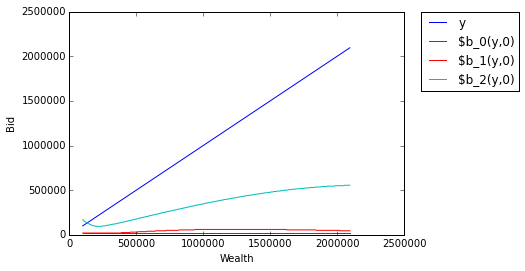

In [25]:
fig, ax = plt.subplots()
ax.plot(y_grid,y_grid, label="y")
for j in [0,1,2]:
    ax.plot(y_grid,sim_output[1][14][j,2,:], label="$b_%d(y,0)" %j)
#for j in [1,2]:
#    ax.plot(y_grid,sim_output[1][1][j,4,:], label="$b_%d(y,8)" %j)
#for j in [1,2]:
#    ax.plot(y_grid,sim_output[1][1][j,8,:], label="$b_%d(y,8)" %j)
ax.set_xlabel("Wealth")
ax.set_ylabel("Bid")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

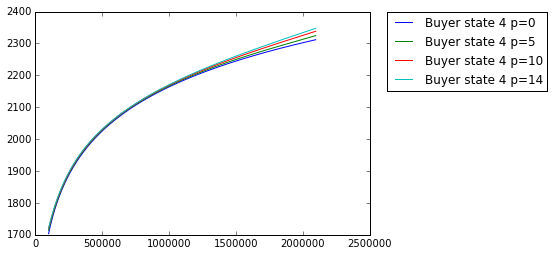

In [16]:
fig, ax = plt.subplots()
for p in [0,5,10,14]:
    ax.plot(y_grid,sim_output[2][p][1,4,:], label="Buyer state 4 p=%d" %p)
    #ax.plot(y_grid,sim_output[2][p][1,0,:], label="Buyer state 0 p=%d" %p)
#ax.plot(y_grid,sim_output[2][1][1,4,:], label="Buyer")
#ax.plot(y_grid,sim_output[2][2][1,4,:], label="Buyer")
#ax.plot(y_grid,sim_output[2][3][1,4,:], label="Buyer")
#ax.plot(y_grid,sim_output[2][4][1,4,:], label="Buyer")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [17]:
f_param = param1
f_set = set1
(f_beta,f_rho,f_w,f_J,f_alpha,f_sigma) = (f_param[0],f_param[1],f_param[2],f_param[3],f_param[4],f_param[5])
(f_y_grid,f_lyg,f_b_grid,f_n_draws,f_state_grid) = (f_set[0],f_set[1],f_set[2],f_set[3],f_set[4])
(f_lyg,f_lbg,f_lsg) = (len(f_y_grid),len(f_b_grid),len(f_state_grid))



In [18]:
bid_now = sim_output[1][14]
f_y_realis = y_realis_states
f_rival_bidders_ids = rival_bidders_ids
distr_bids1 = np.array([[np.interp(f_y_realis[s,:],f_y_grid,bid_now[j,s,:]) for s in np.arange(f_lsg)] for j in np.arange(f_J)])
distr_b_bar_now = np.array([[[np.sort(distr_bids1[j,s,f_rival_bidders_ids[i]])[-1] for i in np.arange(f_n_draws)] for s in np.arange(f_lsg)] for j in np.arange(f_J)])


win_bool = (bid_now.reshape(f_J,f_lsg,f_lyg,1)>distr_b_bar_now.reshape(f_J,f_lsg,1,f_n_draws)) #dimensions: J x states x y_gridpoints x n_draws
win_prob = np.mean(win_bool,axis=3) #dimensions: J x states x y_gridpoints



In [19]:
#np.interp(f_y_realis[5,:],f_y_grid,bid_now[1,5,:])

f_y_realis[5,:][0]

247584.44295161281

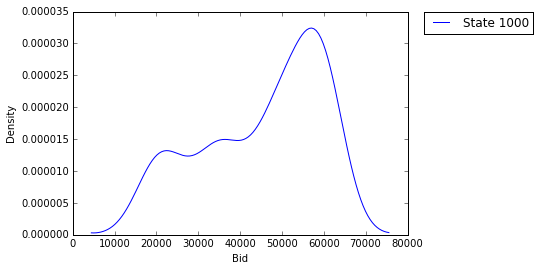

In [20]:
fig, ax = plt.subplots()
for s in [3]: 
    sns.distplot(distr_b_bar_now[1,s,:],hist=False, label="State %d" %state_grid[s])
ax.set_xlabel("Bid")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

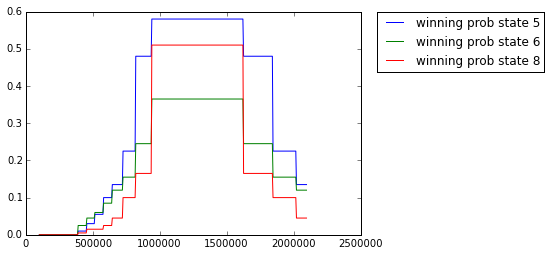

In [21]:
win_prob.shape

fig, ax = plt.subplots()
ax.plot(y_grid,win_prob[1,5,:], label="winning prob state 5")
ax.plot(y_grid,win_prob[1,6,:], label="winning prob state 6")
ax.plot(y_grid,win_prob[1,8,:], label="winning prob state 8")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

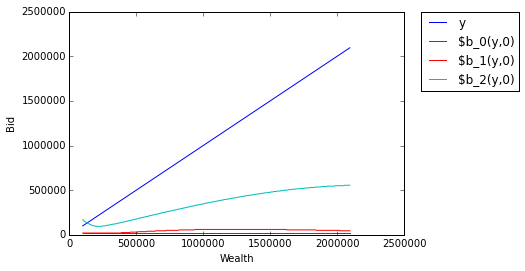

In [22]:
fig, ax = plt.subplots()
ax.plot(y_grid,y_grid, label="y")
for j in range(J):
    ax.plot(y_grid,bid_now[j,5,:], label="$b_%d(y,0)" %j)
ax.set_xlabel("Wealth")
ax.set_ylabel("Bid")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [19]:
    #V1 = utility of composite good consumption plus continuation value of not winning (if inactive or active but losing the auction)
    V1 = (f_alpha*np.log((1-f_beta)*f_y_grid)).reshape(1,1,f_lyg) + (1-f_sigma*win_prob)*f_beta*f_EB.reshape(1,f_lsg,f_lyg) #dimensions: J x states x y_gridpoints
    #V2 = expected utility of winning
    y_buy = y_grid.reshape(1,1,f_lyg,1) - distr_b_bar_now.reshape(f_J,f_lsg,1,f_n_draws) #dimensions: J x S x Y x n_draws (b_bar)
    ES_buy = np.array([[f_ES_interp[j,s](y_buy[j,s,:,:]) for s in np.arange(f_lsg)] for j in np.arange(f_J)]) #dimensions: J x S x Y x n_draws (b_bar)
    V2_per_b_bar = f_w.reshape(f_J,1,1,1) - (f_alpha*distr_b_bar_now.reshape(f_J,f_lsg,1,f_n_draws) / ((1-f_beta) * f_y_grid.reshape(1,1,f_lyg,1))) + f_beta*ES_buy #dimensions: J x S x Y x n_draws (b_bar)
    V2 = f_sigma*np.mean(win_bool * V2_per_b_bar,axis=3)



[7.228083450145277,
 12.862584443927517,
 19.23118479703453,
 218.66130558866962,
 168.95572506784538]